In [1]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

from sentinelhub import SHConfig
from sentinelhub import (
    CRS,
    BBox,
    DataCollection,
    DownloadRequest,
    MimeType,
    MosaickingOrder,
    SentinelHubDownloadClient,
    SentinelHubRequest,
    bbox_to_dimensions,
)

In [2]:
from sentinelhub import SHConfig
from dotenv import load_dotenv
import os
import numpy as np
from utils import get_map
import datetime
import os
import matplotlib.pyplot as plt
import numpy as np
from sentinelhub import CRS, BBox, bbox_to_dimensions
from utils import evalscript_true_color, evalscript_ndvi, evalscript_ndwi
from utils import center_crop
from config import IMAGE_SIZE
from utils import to_grayscale
import cv2
from utils import generated_lsm_mask
from PIL import Image
import numpy as np
from torch.utils.data import DataLoader
from dataset import Image_dataset
from generator_model import Generator
from torch import optim
import torch
from config import DEVICE

# Load model
gen = Generator(in_channels=1, inter_images=4, out_channels=1)
checkpoint = torch.load("model/gen_LSM_v1.pth.tar", map_location=torch.device(DEVICE))
gen.load_state_dict(checkpoint['state_dict'])

optimizer = optim.Adam(gen.parameters())
optimizer.load_state_dict(checkpoint['optimizer'])

config_sentinel = SHConfig(sh_client_id=os.environ.get("sh_client_id"), sh_client_secret=os.environ.get("sh_client_secret"))
config_sentinel.sh_client_id

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 2.0.2 (you have 1.4.14). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


torch.Size([5, 128, 100, 100])


'8a2ee8ea-c74f-4bcb-ace8-266a2a3f4d32'

In [3]:
from sentinelhub import BBox, bbox_to_dimensions, CRS
import math

def divide_bbox(cords, resolution, grid_size):
    # Original bounding box
    bbox = BBox(bbox=cords, crs=CRS.WGS84)

    # Dimensions of the entire bounding box in pixels
    original_size = bbox_to_dimensions(bbox, resolution=resolution)
    print(f"Original bounding box dimensions: {original_size}")

    # Pixel-to-degree conversion
    grid_width_m = grid_size[0] * resolution  # Grid width in meters
    grid_height_m = grid_size[1] * resolution  # Grid height in meters

    # Convert meters to degrees (approximation using latitude for longitude adjustment)
    lat_extent = cords[3] - cords[1]  # Max lat - Min lat
    lon_extent = cords[2] - cords[0]  # Max lon - Min lon
    lat_to_m = 111000  # Approximate meters per degree of latitude
    lon_to_m = 111000 * abs(math.cos(math.radians((cords[1] + cords[3]) / 2)))  # Adjust for longitude

    lat_step = grid_height_m / lat_to_m  # Latitude step in degrees
    lon_step = grid_width_m / lon_to_m  # Longitude step in degrees

    # Generate sub-boxes
    sub_boxes = []
    lat_start = cords[1]
    while lat_start + lat_step <= cords[3]:
        row = []
        lon_start = cords[0]
        while lon_start + lon_step <= cords[2]:
            row.append((
                lon_start,
                lat_start,
                lon_start + lon_step,
                lat_start + lat_step
            ))
            lon_start += lon_step
        sub_boxes.append(row)
        lat_start += lat_step

    return sub_boxes


In [4]:
import math

def add_km_to_lat_long(lat, lon, d_lat_km, d_lon_km):
    new_lat = lat + (d_lat_km / 111)
    new_lon = lon + (d_lon_km / (111 * math.cos(math.radians(lat))))
    return new_lat, new_lon

In [31]:
import numpy as np
import folium

grid = 2

additional_km = 1.4 * grid # dont change/exceed this

lat1, long1 = 44.664106, -109.121194

# lat1 = 12.886612
# long1 = 80.084066

# lat2 = 12.889583
# long2 = 80.087199

a = {"type":"Polygon","coordinates":[
    [
        [lat1, long1],[0, 0],[0, 0],[0, 0],[0, 0]
     ]
    ]
}

min_lon, min_lat = a['coordinates'][0][0][1], a['coordinates'][0][0][0] # Lower-left corner

max_lat, max_lon = add_km_to_lat_long(min_lat, min_lon, additional_km, additional_km)

lon = np.linspace(min_lon, max_lon, grid+1)
lat = np.linspace(min_lat, max_lat, grid+1)

latlons = []
for i in range(len(lat)-1):
    for k in range(len(lon)-1):
        latlons.append((lat[k], lon[i], lat[k+1], lon[i+1]))

m = folium.Map(location=((min_lat+max_lat)/2,(min_lon+max_lon)/2), zoom_start=11)
cords = []
for k in latlons:
    cord = [(k[0], k[1]), (k[2], k[3])]
    cords.append([k[1], k[0], k[3], k[2]])
    folium.Rectangle(cord, color='red', fill='pink',fill_opcity=0.5).add_to(m)
m

In [32]:
actual_grid = []
for row in range(grid):
    g = []
    for col in range(grid):
        g.append(cords[row * grid + col])  # Correct indexing
    actual_grid.append(g)

sub_boxes = np.array(actual_grid)

In [33]:
from tqdm import tqdm
from time import time

def generate_grid_pred(cords_grid, columns=None, rows=None):

    if not columns: columns = len(cords_grid[0])
    if not rows: rows = len(cords_grid)
    
    grid_pred, grid_gray = [], []
    resolution = 0.8
    for row in tqdm(cords_grid[:rows], total=rows): 
        grid_pred_row, grid_gray_row = [], []
        for column in row[:columns]:  
            column = list(column)
            # import pdb; pdb.set_trace()
            print(column)
            maps = get_map(column, start_date="2024-11-06", end_date="2024-12-06",
                evalscript_ndvi=evalscript_ndvi,
                evalscript_true_color=evalscript_true_color,
                evalscript_ndwi=evalscript_ndwi)
            
            new_shape = (IMAGE_SIZE, IMAGE_SIZE)

            gray_image = cv2.resize(to_grayscale(maps[0]), (new_shape[0], new_shape[1]))
            NDVI = cv2.resize(maps[1], (new_shape[0], new_shape[1]))
            Slope = cv2.resize(maps[2], (new_shape[0], new_shape[1]))
            Elevation = cv2.resize(maps[3], (new_shape[0], new_shape[1]))
            NDWI = cv2.resize(maps[4], (new_shape[0], new_shape[1]))

            gray_image_n = cv2.normalize(gray_image, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
            NDVI_n = cv2.normalize(NDVI, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
            Slope_n = cv2.normalize(Slope, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
            Elevation_n = cv2.normalize(Elevation, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
            NDWI_n = cv2.normalize(NDWI, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)

            canvas = np.ones((128, 128*5))
            canvas[:, 0:128] = gray_image_n
            canvas[:, 128:128*2] = NDVI_n
            canvas[:, 128*2:128*3] = Slope_n
            canvas[:, 128*3:128*4] = Elevation_n
            canvas[:, 128*4:128*5] = NDWI_n

            pred = generated_lsm_mask(gen, canvas, already_grayscale=True)
            grid_pred_row.append(pred)
            grid_gray_row.append(gray_image_n)
        grid_pred.append(grid_pred_row)
        grid_gray.append(grid_gray_row)
        
    return grid_pred, grid_gray

    

In [34]:
a = generate_grid_pred(sub_boxes)

  0%|          | 0/2 [00:00<?, ?it/s]

[-109.121194, 44.664106, -109.10346072739424, 44.67671861261261]
[-109.121194, 44.67671861261261, -109.10346072739424, 44.689331225225224]


 50%|█████     | 1/2 [00:36<00:36, 36.28s/it]

[-109.10346072739424, 44.664106, -109.08572745478845, 44.67671861261261]
[-109.10346072739424, 44.67671861261261, -109.08572745478845, 44.689331225225224]


100%|██████████| 2/2 [01:13<00:00, 36.79s/it]


In [35]:
from config import IMAGE_RESIZED

rows = len(a[0])
columns = len(a[0][0])
option = 0

grid_canvas = np.zeros((IMAGE_RESIZED*rows, IMAGE_RESIZED*columns))
for row in range(rows):
    for column in range(columns):
        start_row = row * IMAGE_RESIZED
        end_row = (row + 1) * IMAGE_RESIZED
        start_col = column * IMAGE_RESIZED
        end_col = (column + 1) * IMAGE_RESIZED
        # Swap rows and columns and flip rows
        flipped_row = rows - 1 - row
        grid_canvas[start_row:end_row, start_col:end_col] = cv2.resize(a[option][column][flipped_row], (IMAGE_RESIZED, IMAGE_RESIZED))

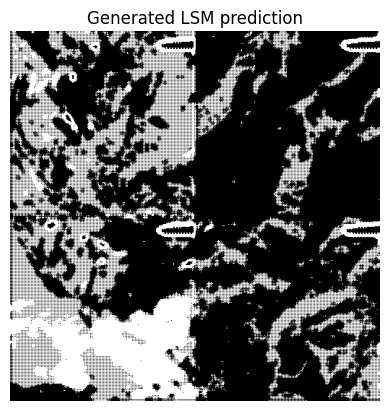

In [36]:
thres_min = 0.2
thres_max = 0.9

blurred_image = cv2.blur(grid_canvas, (5,5))
thresholded_image = (blurred_image > thres_min) & (blurred_image < thres_max)
# mask = (blurred_image ) 

plt.imshow(thresholded_image, cmap="gray")
plt.title("Generated LSM prediction")
plt.axis("off")
plt.show()

In [37]:
cords = sub_boxes[0][0]
resolution = 0.8
bbox = BBox(bbox=list(cords), crs=CRS.WGS84)
size = bbox_to_dimensions(bbox, resolution=resolution)

print(f"Image shape at {resolution} m resolution: {size} pixels")

Image shape at 0.8 m resolution: (1716, 1792) pixels


In [38]:
maps = get_map(list(cords), start_date="2021-06-12", end_date="2023-06-13", 
        evalscript_ndvi=evalscript_ndvi, 
        evalscript_true_color=evalscript_true_color, 
        evalscript_ndwi=evalscript_ndwi)

In [39]:
# gray_image, NDVI, Slope, Elevation, NDWI

In [42]:
new_shape = (IMAGE_SIZE, IMAGE_SIZE)

gray_image = cv2.resize(to_grayscale(maps[0]), (new_shape[0], new_shape[1]))
NDVI = cv2.resize(maps[1], (new_shape[0], new_shape[1]))
Slope = cv2.resize(maps[2], (new_shape[0], new_shape[1]))
Elevation = cv2.resize(maps[3], (new_shape[0], new_shape[1]))
NDWI = cv2.resize(maps[4], (new_shape[0], new_shape[1]))

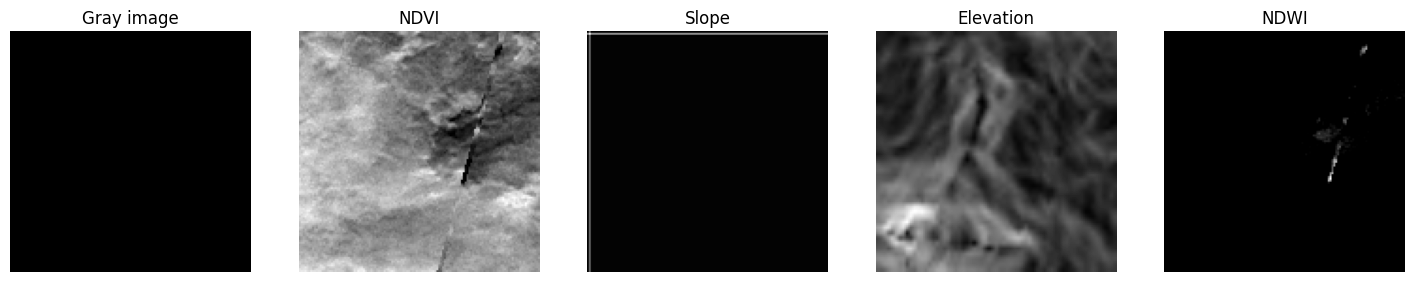

In [43]:
fig,(ax1,ax2, ax3, ax4, ax5)= plt.subplots(1,5,figsize=(18,6))

ax1.set_title("Gray image")
ax2.set_title("NDVI")
ax3.set_title("Slope")
ax4.set_title("Elevation")
ax5.set_title("NDWI")

ax1.imshow(gray_image, cmap="gray")
ax2.imshow(NDVI, cmap="gray")
ax3.imshow(Slope, cmap="gray")
ax4.imshow(Elevation, cmap="gray")
ax5.imshow(NDWI, cmap="gray")

ax1.axis("off"); ax2.axis("off"), ax3.axis("off"); ax4.axis("off"), ax5.axis("off")
plt.show()


In [44]:
# gray_image_n = cv2.normalize(gray_image, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
# NDVI_n = cv2.normalize(NDVI, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
# Slope_n = cv2.normalize(Slope, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
# Elevation_n = cv2.normalize(Elevation, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
# NDWI_n = cv2.normalize(NDWI, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)

In [ ]:
# canvas = np.ones((128, 128*5))
# canvas[:, 0:128] = gray_image_n
# canvas[:, 128:128*2] = NDVI_n
# canvas[:, 128*2:128*3] = Slope_n
# canvas[:, 128*3:128*4] = Elevation_n
# canvas[:, 128*4:128*5] = NDWI_n

# plt.imshow(canvas, cmap="gray")

In [ ]:
# pred = generated_lsm_mask(gen, canvas, already_grayscale=True)
# b_i = cv2.blur(pred, (5, 5))
# thresholded = (b_i > 0.1) & (b_i < 0.9)

# plt.imshow(thresholded.astype(float), cmap="gray")
# plt.title("Thresholded and Blurred Prediction")
# plt.axis("off")
# plt.show()